#     **Taxi Fare Price Prediction**

## Data Discription's

**unique_id**: Unique identifier or key for each record in the dataset - (string)    

**date_time_of_pickup**: time when the ride started - (timestamp)

**longitude_of_pickup**: Longitude of the taxi ride pickup point - (float) - (Numerical) 
 
**latitude_of_pickup**: Latitude of the taxi ride pickup point - (float) - (Numerical)
    
**longitude__of_dropoff**: Longitude of the taxi ride dropoff point  - (float) - (Numerical)
    
**latitude_of_dropoff**: Latitude of the taxi ride dropoff point - (float) - (Numerical)
    
**no_of_passenger**: count of the passengers during the ride - (integer) - (Numerical)
    
**amount**: (target variable)dollar amount of the cost of the taxi ride
   

# Import Libraries

In [112]:
from warnings import filterwarnings
filterwarnings('ignore')
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import radians, cos, sin, sqrt, asin
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [113]:
plt.rcParams['figure.figsize'] = [15,8]

# Set Options

In [114]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format

# Read Data

<table align="left">
    <tr>
        <td width="8%">
            <img src="todo.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>Read and display data to get insights from the data.
                    </b> 
                </font>
            </div>
        </td>
    </tr>
</table>

In [116]:
df_taxi = pd.read_csv('TaxiFare.csv')
df_taxi.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.500000,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.900000,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.700000,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.700000,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.300000,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [117]:
df_taxi = df_taxi.drop('unique_id', axis = 1)

# Prepare and Analyze the Data

<a id='Data_Understanding'></a>
## 4.1 Understand the Data

In [118]:
df_taxi.shape

(50000, 7)

the dataframe has 7 columns and 50000 rows.

In [119]:
df_taxi.dtypes

amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

Change the incorrect data type

In [120]:
df_taxi.date_time_of_pickup = pd.to_datetime(df_taxi.date_time_of_pickup, errors='coerce')

Recheck the data type after the conversion

In [121]:
df_taxi.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object

### Feature Engineering
We will extract date time features from the variable 'date_time_of_pickup'.

In [122]:
# extract various date time components as seperate variables
df_taxi = df_taxi.assign(hour = df_taxi.date_time_of_pickup.dt.hour, 
                         day = df_taxi.date_time_of_pickup.dt.day,
                        month = df_taxi.date_time_of_pickup.dt.month, 
                        year = df_taxi.date_time_of_pickup.dt.year, 
                        dayofweek = df_taxi.date_time_of_pickup.dt.dayofweek)

We will add a new variable which measures the distance between the pickup and dropoff point. We will use the Haversine formula to compute the distance between two points of the journey, using the logitude and latitude values. 

In [123]:
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [124]:
#new variable travel distance

df_taxi['travel_dist_km'] = distance_transform(df_taxi['longitude_of_pickup'].to_numpy(),
                                                df_taxi['latitude_of_pickup'].to_numpy(),
                                                df_taxi['longitude_of_dropoff'].to_numpy(),
                                                df_taxi['latitude_of_dropoff'].to_numpy()
                                              )

In [125]:
#newly added vaiarbles
df_taxi.head(5)

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


Drop the redundant variable.

In [126]:
df_taxi = df_taxi.drop('date_time_of_pickup',axis=1)

In [127]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   hour                  50000 non-null  int64  
 7   day                   50000 non-null  int64  
 8   month                 50000 non-null  int64  
 9   year                  50000 non-null  int64  
 10  dayofweek             50000 non-null  int64  
 11  travel_dist_km        50000 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 4.6 MB


As now have the required features, after having extracted new ones and dropping the redundant variables.

For numerical variables, use the describe

In [128]:
df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amount,50000.000000,11.364171,9.685557,-5.000000,6.000000,8.500000,12.500000,200.000000
longitude_of_pickup,50000.000000,-72.509756,10.393860,-75.423848,-73.992062,-73.981840,-73.967148,40.783472
latitude_of_pickup,50000.000000,39.933759,6.224857,-74.006893,40.734880,40.752678,40.767360,401.083332
longitude_of_dropoff,50000.000000,-72.504616,10.407570,-84.654241,-73.991152,-73.980082,-73.963584,40.851027
latitude_of_dropoff,50000.000000,39.926251,6.014737,-74.006377,40.734371,40.753372,40.768167,43.415190
no_of_passenger,50000.000000,1.667840,1.289195,0.000000,1.000000,1.000000,2.000000,6.000000
hour,50000.000000,13.489080,6.506935,0.000000,9.000000,14.000000,19.000000,23.000000
day,50000.000000,15.672040,8.660789,1.000000,8.000000,16.000000,23.000000,31.000000
month,50000.000000,6.273300,3.461157,1.000000,3.000000,6.000000,9.000000,12.000000
year,50000.000000,2011.739260,1.862639,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000


### Discover Outliers

In [129]:
df_taxi = df_taxi.loc[(df_taxi.amount >= 2.5)]

In [130]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49990, 12)


Remove the observations with travel distance more than 130 kms.As seen from descriptive stats there are obs with tarvel distance more than 130 km, as that is the limit for trips in and around NYC

In [131]:
#We will only keep the observation where travel distance is less than or equal to 130
df_taxi = df_taxi.loc[(df_taxi.travel_dist_km >= 1) | (df_taxi.travel_dist_km <= 130)]
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49990, 12)


Remove the observations with unreal longitude and latitude values , that is , 90< latitude <-90, 180 < longitude < -180.

In [132]:
incorrect_coordinates = df_taxi.loc[(df_taxi.latitude_of_pickup > 90) |(df_taxi.latitude_of_pickup < -90) |
                                   (df_taxi.latitude_of_dropoff > 90) |(df_taxi.latitude_of_dropoff < -90) |
                                   (df_taxi.longitude_of_pickup > 180) |(df_taxi.longitude_of_pickup < -180) |
                                   (df_taxi.longitude_of_dropoff > 90) |(df_taxi.longitude_of_dropoff < -90)
                                    ].index

In [133]:
df_taxi.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [134]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49989, 12)


### Missing Values

In [135]:
Total = df_taxi.isnull().sum().sort_values(ascending = False)          
Percent = (df_taxi.isnull().sum()*100/df_taxi.isnull().count()).sort_values(ascending = False)   
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data['Type'] = df_taxi[missing_data.index].dtypes
missing_data

,Total,Percentage of Missing Values,Type
travel_dist_km,0,0.000000,float64
dayofweek,0,0.000000,int64
year,0,0.000000,int64
month,0,0.000000,int64
day,0,0.000000,int64
hour,0,0.000000,int64
no_of_passenger,0,0.000000,int64
latitude_of_dropoff,0,0.000000,float64
longitude_of_dropoff,0,0.000000,float64
latitude_of_pickup,0,0.000000,float64


missing values using heatmap

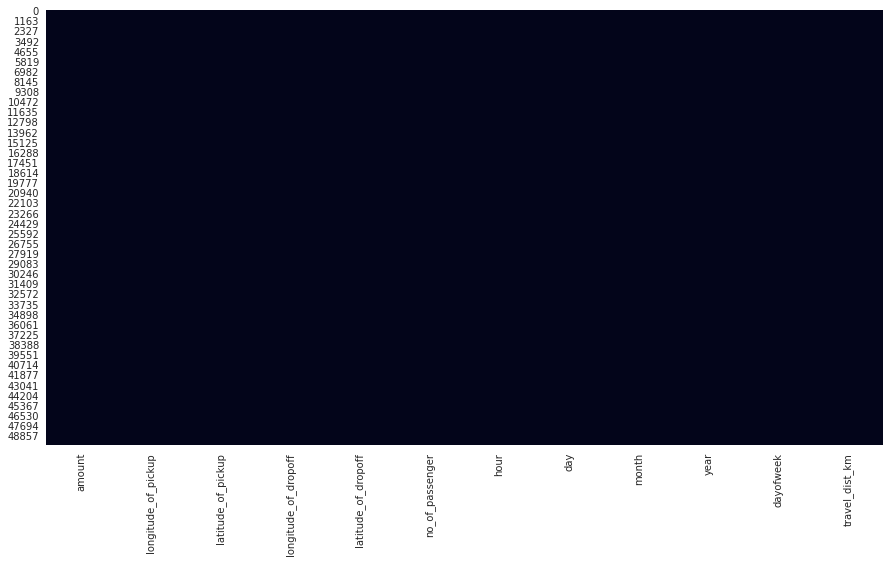

In [136]:
sns.heatmap(df_taxi.isnull(), cbar=False)
plt.show()

# correlation matrix

In [137]:
corr = df_taxi.corr()
corr

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
amount,1.000000,0.005905,-0.006563,0.004452,-0.005600,0.016506,-0.022009,-0.001417,0.026742,0.121081,0.000542,0.016451
longitude_of_pickup,0.005905,1.000000,-0.984132,0.956613,-0.947401,-0.005614,0.004913,0.006008,0.000402,-0.001264,-0.003224,0.143712
latitude_of_pickup,-0.006563,-0.984132,1.000000,-0.943741,0.961374,0.003982,-0.004313,-0.008884,0.000498,-0.000925,0.001911,-0.130943
longitude_of_dropoff,0.004452,0.956613,-0.943741,1.000000,-0.982102,-0.004874,0.005506,0.005221,0.001322,-0.000327,-0.002441,0.143172
latitude_of_dropoff,-0.005600,-0.947401,0.961374,-0.982102,1.000000,0.002898,-0.004530,-0.008012,-0.000341,-0.001817,0.001626,-0.124844
no_of_passenger,0.016506,-0.005614,0.003982,-0.004874,0.002898,1.000000,0.011400,0.006787,0.009099,0.006385,0.038581,-0.005371
hour,-0.022009,0.004913,-0.004313,0.005506,-0.004530,0.011400,1.000000,-0.008192,-0.001916,0.004167,-0.091267,0.000644
day,-0.001417,0.006008,-0.008884,0.005221,-0.008012,0.006787,-0.008192,1.000000,-0.017266,-0.011155,0.008422,0.010610
month,0.026742,0.000402,0.000498,0.001322,-0.000341,0.009099,-0.001916,-0.017266,1.000000,-0.115726,-0.010004,-0.009217
year,0.121081,-0.001264,-0.000925,-0.000327,-0.001817,0.006385,0.004167,-0.011155,-0.115726,1.000000,0.006808,0.022136


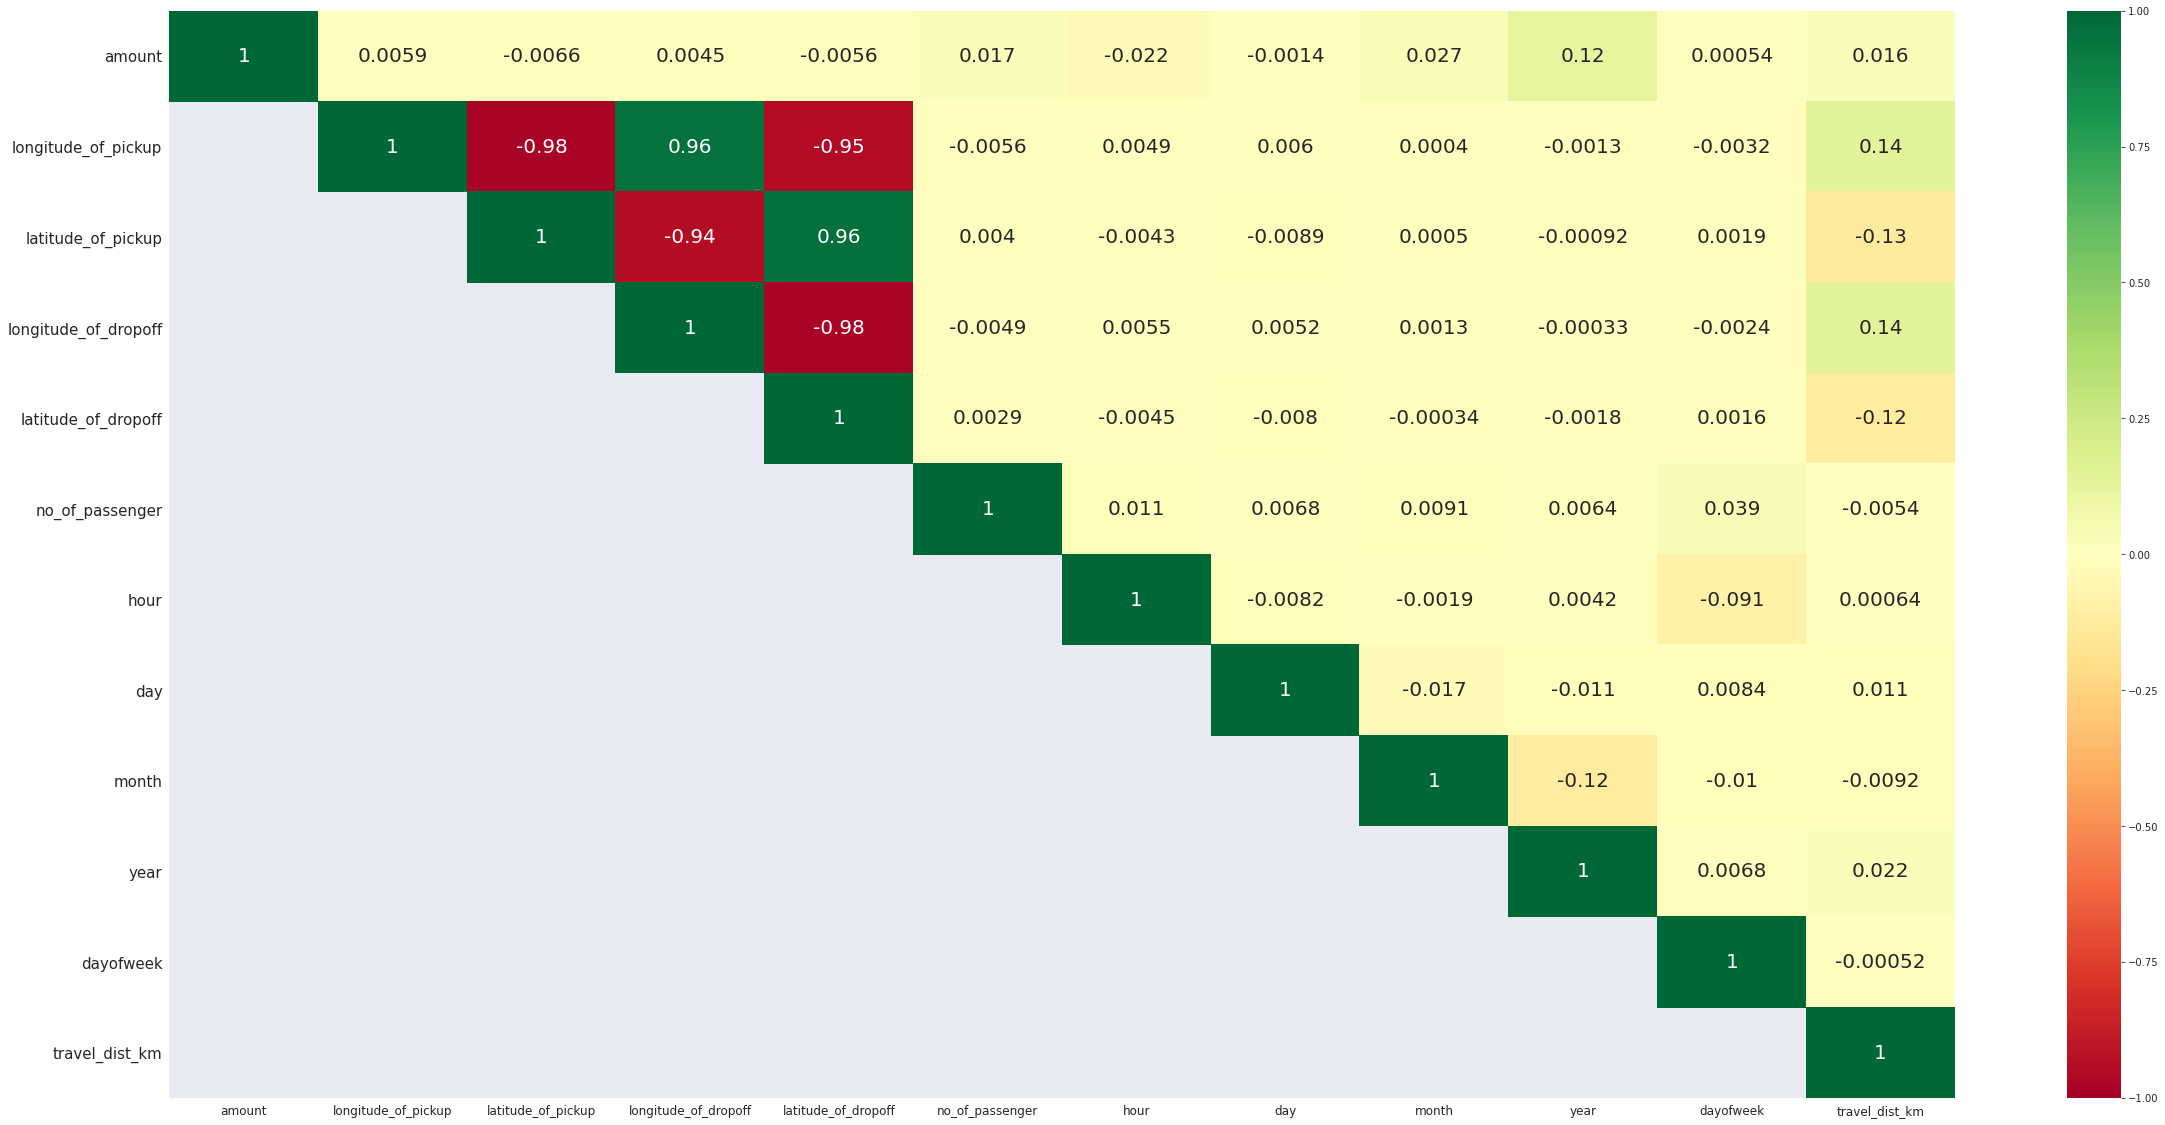

In [138]:
plt.figure(figsize = (40,20))
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask, k = -1)] = True
sns.heatmap(corr, cmap = 'RdYlGn', vmax = 1.0, vmin = -1.0, annot = True, annot_kws = {"size": 20}, mask = mask)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)

plt.show()

Heatmap that consider the variables with strong correlation.

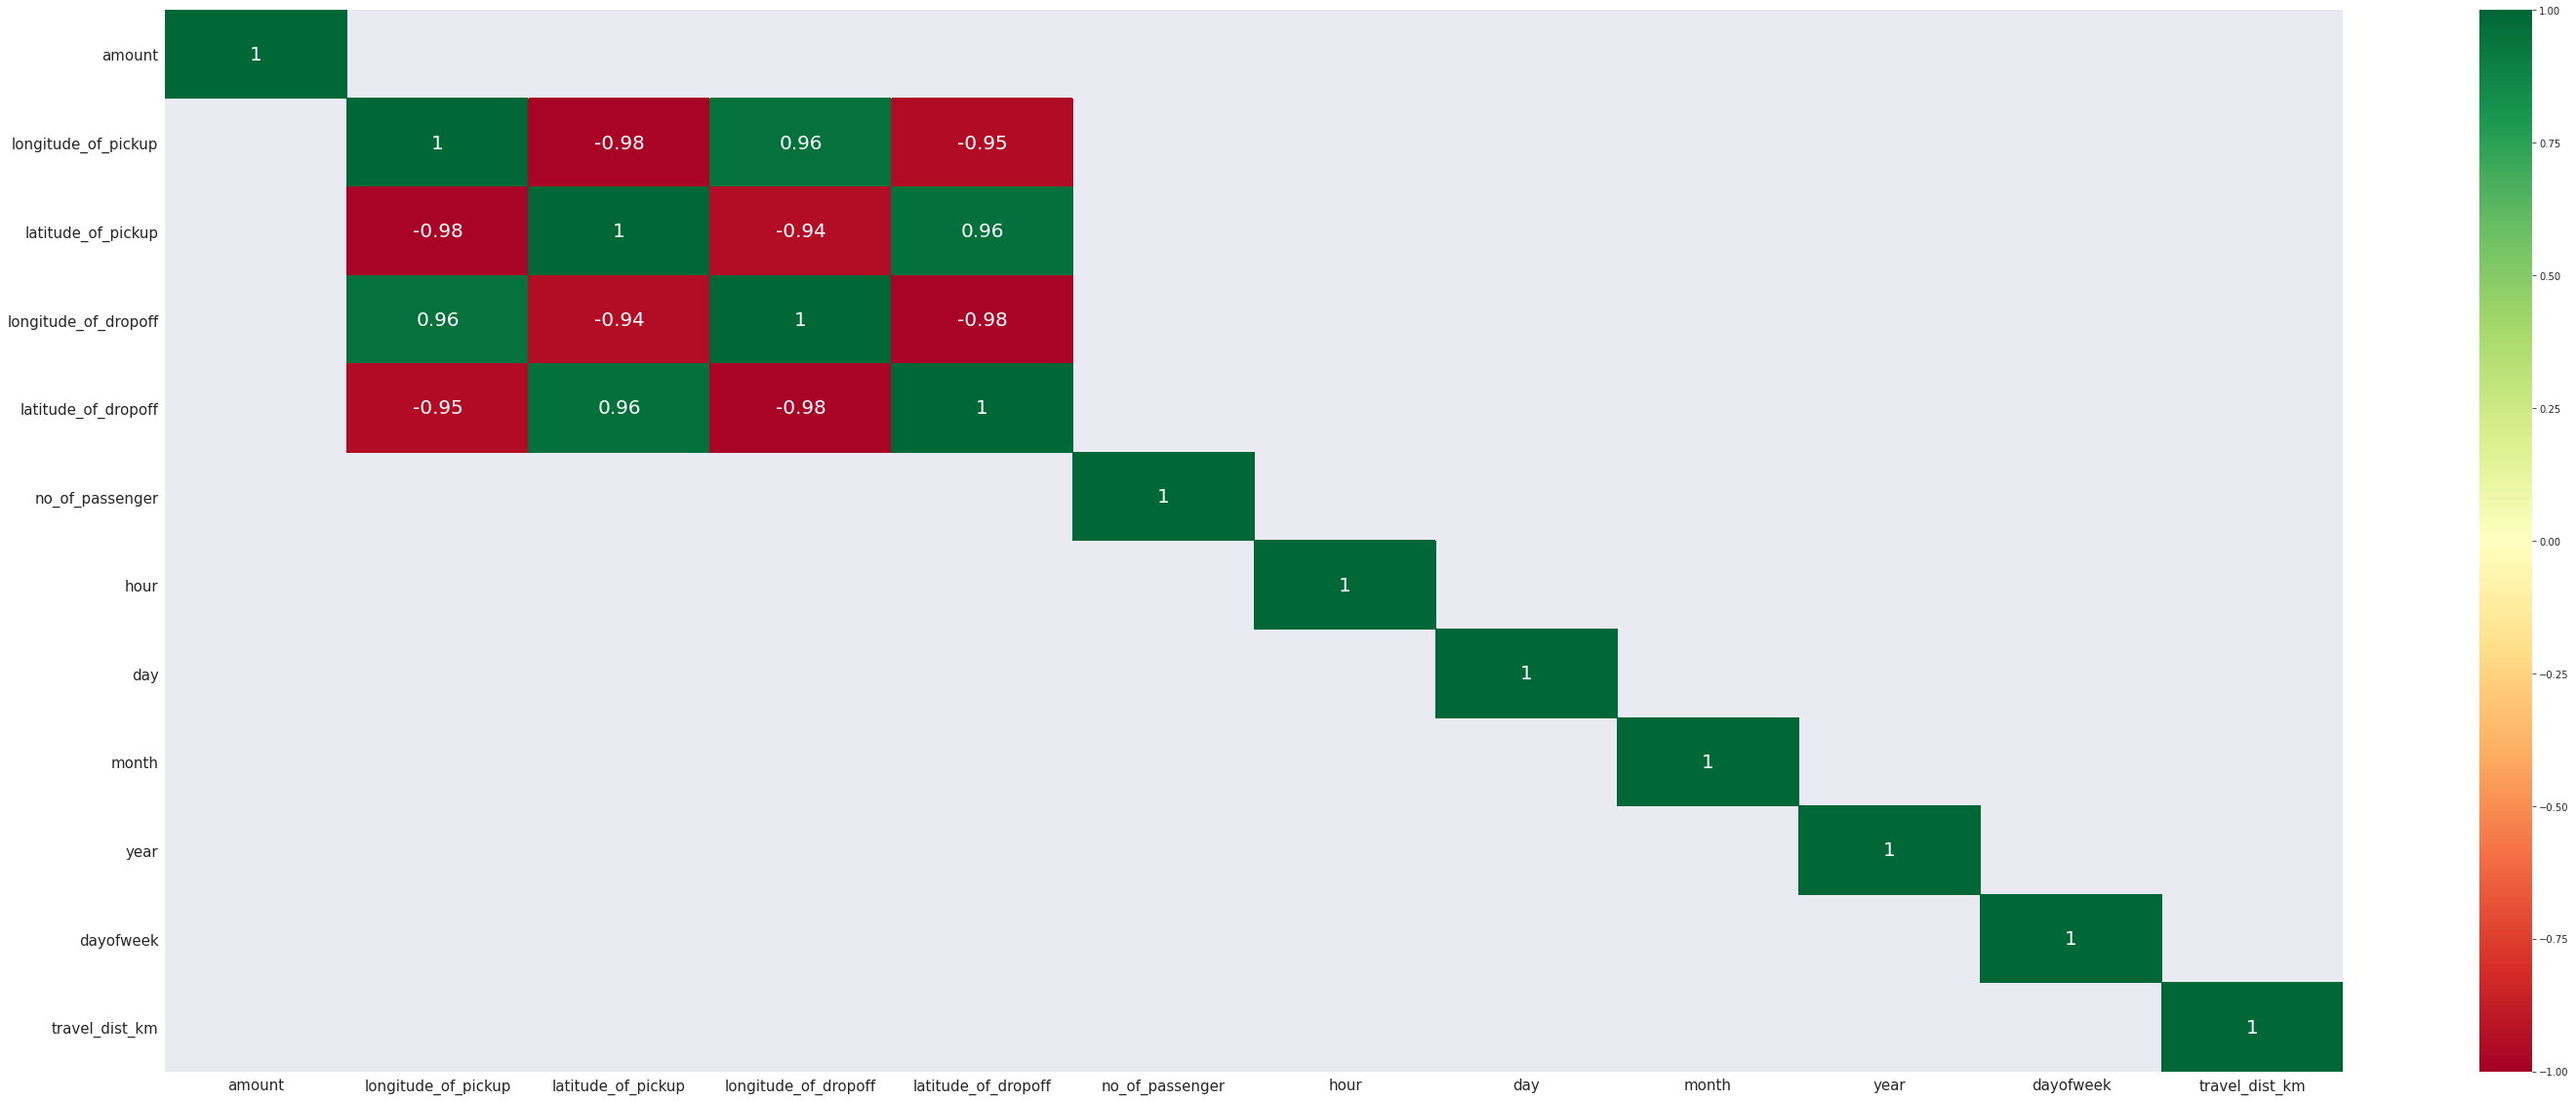

In [139]:
plt.figure(figsize=(50, 20))
sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], cmap = 'RdYlGn', vmax = 1.0, vmin = -1.0, annot = True, annot_kws={"size": 20})
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

## Exploratory Data Analysis

### Peak hours

# We will check for the business during the weekdays and weekends.

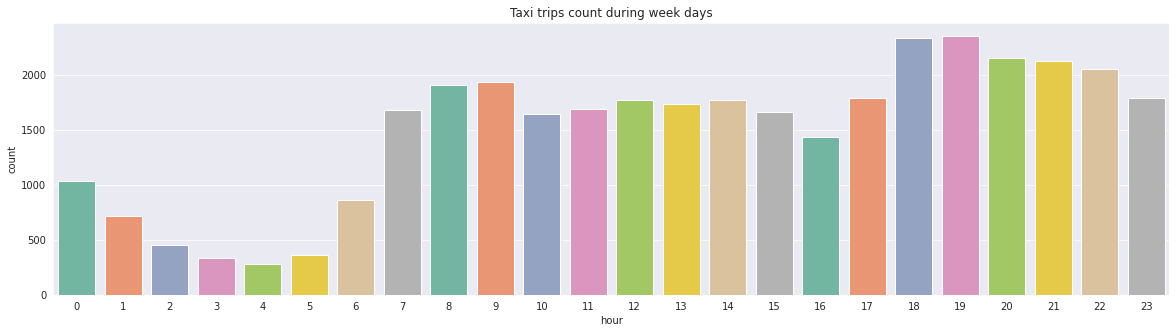

In [140]:
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week days')
sns.set_style("white")

sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <=4)], palette='Set2')

We see that during the weekdays the count of trips start to peak from 8 am and is highest at 9am. In the evening the peak is at 6pm and 7pm.

# Plot a countplot to check the peak hours during weekends

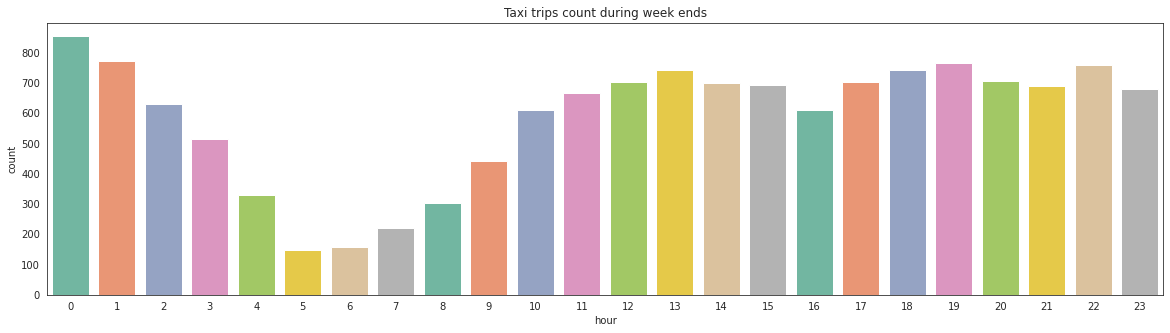

In [141]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week ends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <=6)], palette='Set2')

We see that during the weekends the count of trips is high after 12 midnight to 3am to 4am. This pattern is different from the weekdays. In the evening the demand is almost evenly high after 6pm till late night except.

### Mean fare for each hour during weekdays and weekends

We will check the mean fares for each hour during the weekdays and weekends.

**1. Compute the hourly mean fare for weekdays and weekends**

In [142]:
week_days = df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <= 4)]
week_ends = df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <= 6)]

week_days_fare = week_days.groupby(['hour']).amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).amount.mean().to_frame().reset_index()

**2. Plot the mean fare**

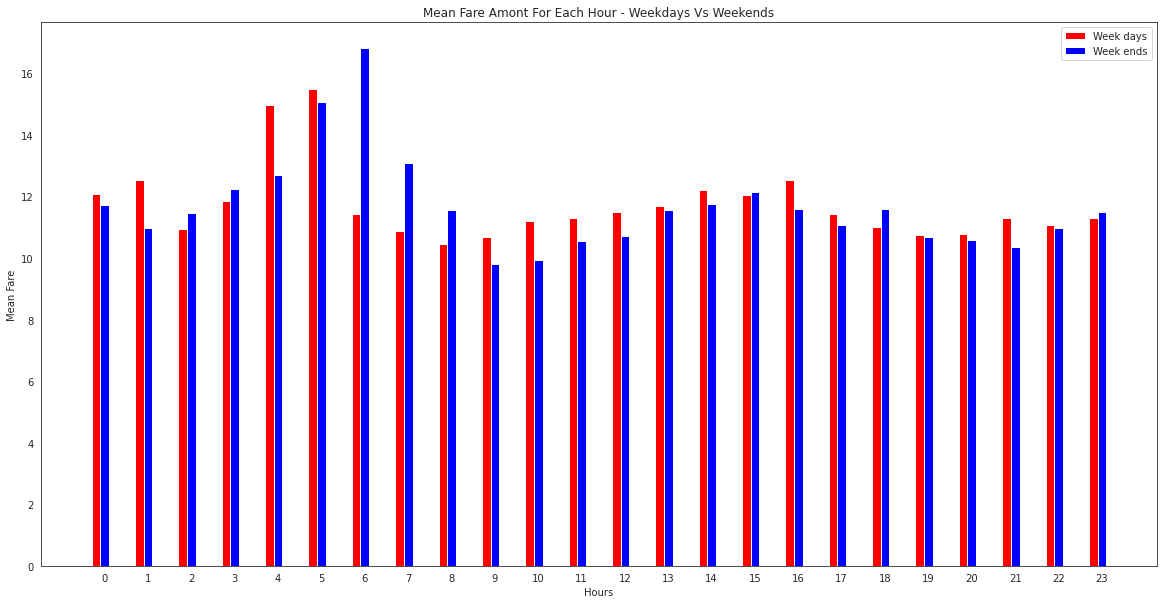

In [143]:
x = np.array(week_days_fare.hour)
y = np.array(week_days_fare.amount)
z = np.array(week_ends_fare.amount)

#Set the figure size, title, x and y labels
plt.figure(figsize = (20,10))
plt.title('Mean Fare Amont For Each Hour - Weekdays Vs Weekends')
plt.xlabel('Hours')
plt.ylabel('Mean Fare')

ax=plt.subplot(1,1,1)
ax.bar(x-0.2, y, width=0.2, color='red', align='center', label = 'Week days')
ax.bar(x, z, width=0.2, color='blue', align='center', label = 'Week ends')
plt.xticks(range(0,24))
plt.legend()
plt.show()


We notice that the mean fares for each hour are different for week days and week ends. Mean fare for weekdays during morning hours 6,7 and 8 is lmuch ess compared to weekends.

### Distribution of key numerical vairables

**1. Distribution of fare 'amount'**

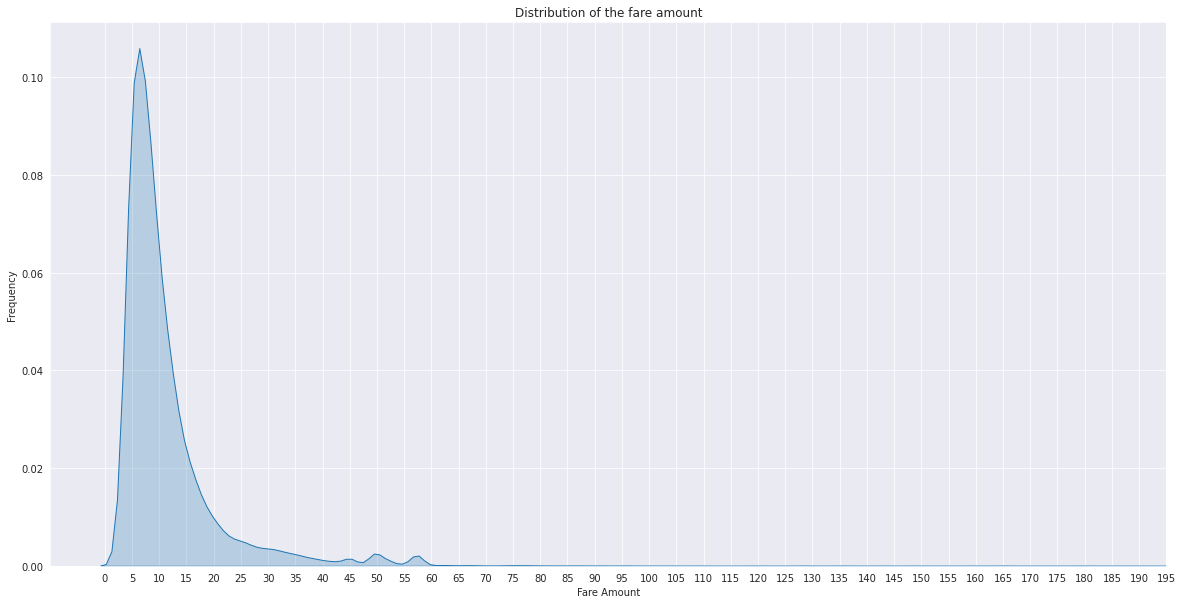

In [144]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df_taxi.amount, shade=True)


We can see that most the trips have a fare amount of 2 to 20 dollars. There are a few small peaks around 50 and 58 dollars as well.

**2. Distribustion of the travel distance in km**

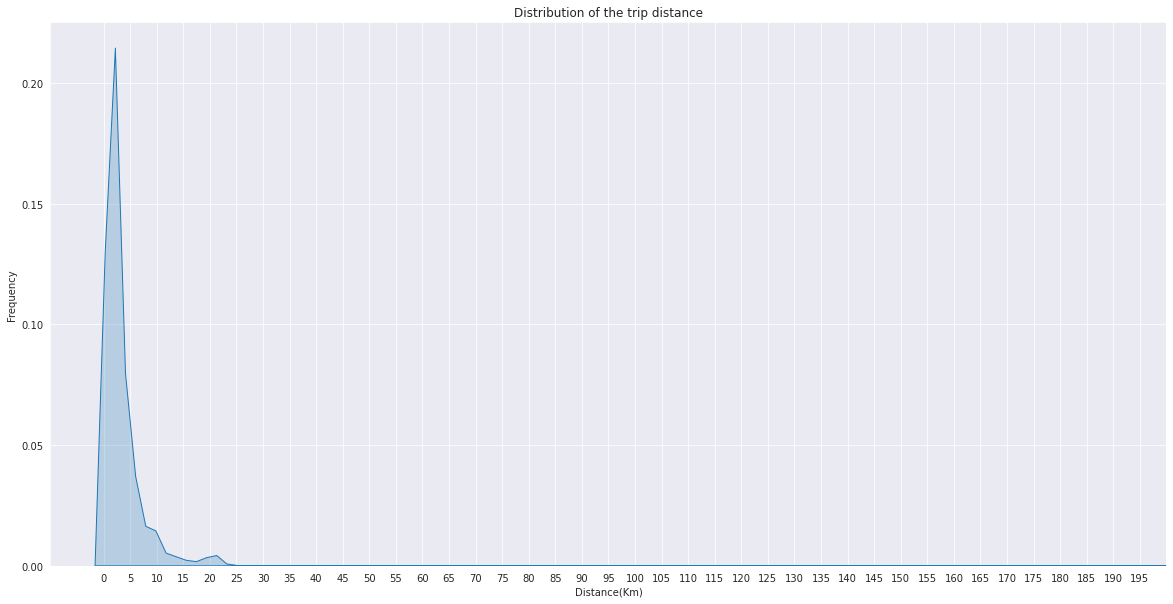

In [145]:
plt.figure(figsize = (20,10))
sns.style = ('darkgrid')
plt.title("Distribution of the trip distance")
plt.xlabel("Distance(Km)")
plt.ylabel("Frequency")
plt.xlim(-10, 200)
plt.xticks(range(0,200,5))

sns.plot = sns.kdeplot(df_taxi[df_taxi.travel_dist_km<600].travel_dist_km, shade=True)

We can see that most the trips have a travel distance of 2.5 km to 25 km. There are a few instances of 0 km as well.

# Random Forest

In [146]:
y = pd.DataFrame(df_taxi['amount'])

Now, use this 'y' as a target variable to build the classification models.

In [147]:
X = df_taxi.drop('amount',axis = 1)

In [148]:
X.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


Use this 'X' as a set of predictors to build the model.

**2. Split the data into training and test sets**

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print("The shape of X_train is:",X_train.shape)
print("The shape of X_test is:",X_test.shape)
print("The shape of y_train is:",y_train.shape)
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (34992, 11)
The shape of X_test is: (14997, 11)
The shape of y_train is: (34992, 1)
The shape of y_test is: (14997, 1)


**3. Build model using RandomForestRegressor**

In [150]:
#intantiate the regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)

# fit the regressor with training dataset
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

**4. Predict the values using test set**

In [151]:
# predict the values on test dataset using predict()
y_pred = rf_reg.predict(X_test)

**5. Compute accuracy measures**

Now we calculate accuray measures Root-mean-square-error (RMSE), R-squared and Adjusted R-squared.

In [165]:
rf_reg_r2score = metrics.r2_score(y_test, y_pred)
print('R2 (Rsquare):', rf_reg_r2score)


rf_reg_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', rf_reg_MAE)

#MSE
rf_reg_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_MSE)

#RMSE
rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_RMSE)

R2 (Rsquare): 0.7873578745191259
Mean Absolute Error (MAE): 2.109603728699712
Mean Squared Error (MSE): 19.970499194879483
Root Mean Squared Error (RMSE): 4.468836447541964


**6. Tabulate the results**

In [166]:
cols = ['Model', 'R2','MAE', 'MSE', 'RMSE']
result_tabulation = pd.DataFrame(columns = cols)

rf_reg_metrics = pd.Series({'Model': "Random Forest ",
                     'R2' :rf_reg_r2score,        
                     'MAE':rf_reg_MAE,
                     'MSE': rf_reg_MSE,
                     'RMSE': rf_reg_RMSE     
                   })

result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

result_tabulation

,Model,R2,MAE,MSE,RMSE
0,Random Forest,0.787358,2.109604,19.970499,4.468836



## Random Forest with GridSearchCV

**1. GridSearch to obtain the optimal values of hyperparameters**

In [167]:
tuned_paramaters = [{'n_estimators': [ 85, 100],
                     'min_samples_split': [15,20],
                     'max_depth': [8, 10]
                     #'min_samples_leaf': [5,10],
                     #'max_leaf_nodes': [10, 15]
                    }]

In [168]:
rf_reg_CV= RandomForestRegressor(random_state = 10)

grid = GridSearchCV(estimator = rf_reg_CV, 
                    param_grid = tuned_paramaters, cv = 4)

dt_grid = grid.fit(X_train, y_train)
print('Best parameters for random forest regressor: ', dt_grid.best_params_, '\n')

Best parameters for random forest regressor:  {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100} 



**2. Build the model using the hyperparameters obtained in step 1**

In [169]:
dt_grid_model = RandomForestRegressor(n_estimators = dt_grid.best_params_.get('n_estimators'),
                                       max_depth = dt_grid.best_params_.get('max_depth'),
                                       min_samples_split = dt_grid.best_params_.get('min_samples_split'),
                                       random_state = 10)

dt_grid_model = dt_grid_model.fit(X_train, y_train)

**3. Predict the values using test set**

In [170]:
y_pred = dt_grid_model.predict(X_test)

**4. Compute accuracy measures**

Now we calculate accuray measures Root-mean-square-error (RMSE), R-squared and Adjusted R-squared.

In [171]:
# R2
rf_reg_CV_R2 = metrics.r2_score(y_test, y_pred)
print('R2Score (R2):', rf_reg_CV_R2)


# MAE
rf_reg_CV_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', rf_reg_CV_MAE)
                                         
# MSE
rf_reg_CV_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_CV_MSE)
                                         
# RMSE
rf_reg_CV_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_CV_RMSE)

R2Score (R2): 0.7873578745191259
Mean Absolute Error (MAE): 2.109603728699712
Mean Squared Error (MSE): 19.970499194879483
Root Mean Squared Error (RMSE): 4.468836447541964


**5. Final results**

In [172]:
rf_reg_metrics = pd.Series({'Model': "Random Forest GridSearch_CV ",
                      'R2': rf_reg_CV_R2,       
                     'MAE':rf_reg_CV_MAE,
                     'MSE': rf_reg_CV_MSE,
                     'RMSE': rf_reg_CV_RMSE     
                   })
result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

result_tabulation

,Model,R2,MAE,MSE,RMSE
0,Random Forest,0.787358,2.109604,19.970499,4.468836
1,Random Forest GridSearch_CV,0.787358,2.109604,19.970499,4.468836
